# Sensitivity Analysis for Unobserved Confounder with DML.

Here we experiment with sensitivity analysis under unobserved confounding, both manually and with [sensitivity.py](https://github.com/vsyrgkanis/dml_sensitivity_python).

## Partially Linear SEM

Consider the SEM
\begin{eqnarray*}
Y & := & \alpha D + \delta A + f_Y(X) + \epsilon_Y,  \\
D & := & \gamma A + f_D(X) + \epsilon_D, \\
A & : =  & f_A(X) + \epsilon_A, \\
X & := &  \epsilon_X,
\end{eqnarray*}
where, conditional on $X$, $\epsilon_Y, \epsilon_D, \epsilon_A$ are mean zero
and mutually uncorrelated. We further normalize
$$
E[\epsilon_A^2] =1.
$$
The key structural
parameter is $\alpha$: $$\alpha = \partial_d Y(d)$$
where $$Y(d) := (Y: do (D=d)).$$

To give context to our example, we can interpret $Y$ as earnings,
$D$ as education, $A$ as ability, and $X$ as a set of observed background variables. In this example, we can interpret $\alpha$ as the returns to schooling.

We start by applying the partialling out operator to get rid of the $X$'s in all of the equations. Define the partialling out operation of any random vector $V$ with respect to another random vector $X$ as the residual that is left after subtracting the best predictor of $V$ given $X$:
$$\tilde V = V - E [V \mid X].$$  
If $f$'s are linear, we can replace $E [V \mid X]$
by linear projection.  After partialling out, we have a simplified system:
\begin{eqnarray*}
\tilde Y & := & \alpha \tilde D + \delta \tilde A + \epsilon_Y,  \\
\tilde D & := & \gamma \tilde A + \epsilon_D, \\
\tilde A & : = & \epsilon_A,
\end{eqnarray*}
where $\epsilon_Y$, $\epsilon_D$, and $\epsilon_A$ are uncorrelated.

Then the projection of $\tilde Y$ on $\tilde D$ recovers
$$
\beta = E [\tilde Y \tilde D]/ E [\tilde D^2] = \alpha +  \phi,
$$
where
$$
\phi =  \delta \gamma/ E \left[(\gamma^2 + \epsilon^2_D)\right],
$$
is the omitted confounder bias or omitted variable bias.

The formula follows from inserting the expression for $\tilde D$ into the definition of $\beta$ and then simplifying the resulting expression using the assumptions on the $\epsilon$'s.

We can use this formula to bound $\phi$ directly by making assumptions on the size of $\delta$
and $\gamma$.  An alternative approach can be based on the following characterization,
based on partial $R^2$'s.  This characterization essentially follows
from Cinelli and Hazlett, with the slight difference that we have adapted
the result to the partially linear model.

*Theorem* [Omitted Confounder Bias in Terms of Partial $R^2$'s]

In the partially linear SEM setting above,
$$
\phi^2 = \frac{R^2_{\tilde Y \sim \tilde A \mid \tilde D} R^2_{\tilde D \sim \tilde A} }{ (1 - R^2_{\tilde D \sim \tilde A}) } \
\frac{E \left[ (\tilde Y - \beta \tilde D)^2 \right] }{E \left[ ( \tilde D )^2 \right]},
$$
where $R^2_{V \sim W \mid X}$ denotes the population $R^2$ in the linear regression of $V$ on $W$, after partialling out $X$ from $V$ and $W$ linearly.


Therefore, if we place bounds on how much of the variation in $\tilde Y$ and in $\tilde D$
the unobserved confounder $\tilde A$ is able to explain, we can bound the omitted confounder bias by $$\sqrt{\phi^2}.$$


# Empirical Example

We consider an empirical example based on data surrounding the Darfur war. Specifically, we are interested in the effect of having experienced direct war violence on attitudes towards peace. Data is described here
https://cran.r-project.org/web/packages/sensemakr/vignettes/sensemakr.html

The main outcome is attitude towards peace -- ``peacefactor``.
The key variable of interest is whether the responders were directly harmed (``directlyharmed``).
We want to know if being directly harmed in the conflict causes people to support peace-enforcing measures.
The measured confounders include dummy variables ``female``, ``farmer``, ``herder``, ``pastvoted``, along with ``age`` and household size (``hhsize``).
There is also a village indicator. We deal with village by and partialling out a full set of village dummy variables before conducting
the analysis. The standard errors will be clustered at the village level.


## Outline

We will:
- mimic the partialling out procedure with machine learning tools;
- invoking sensitivity.py to compute $\phi^2$ and plot sensitivity results.


In [1]:
# Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import patsy
import warnings
from sklearn.base import BaseEstimator
import statsmodels.formula.api as smf
import scipy
warnings.simplefilter('ignore')
np.random.seed(1234)

In [2]:
file = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/darfur.csv"
data = pd.read_csv(file)
data.shape

(1276, 14)

## Preprocessing
Take out village fixed effects and run basic linear analysis

In [3]:
# Get rid of village fixed effects
peacefactorR = smf.ols(formula="peacefactor ~ village", data=data).fit().resid
directlyharmedR = smf.ols(formula="directlyharmed ~ village", data=data).fit().resid
femaleR = smf.ols(formula="female ~ village", data=data).fit().resid
ageR = smf.ols(formula="age ~ village", data=data).fit().resid
farmerR = smf.ols(formula="farmer_dar ~ village", data=data).fit().resid
herderR = smf.ols(formula="herder_dar ~ village", data=data).fit().resid
pastvotedR = smf.ols(formula="pastvoted ~ village", data=data).fit().resid
hhsizeR = smf.ols(formula="hhsize_darfur ~ village", data=data).fit().resid

# Preliminary linear model analysis
# Here we are clustering standard errors at the village level

# Estimating the effect of the treatment, controlling linearly for other factors
model1 = smf.ols(formula="peacefactorR ~ directlyharmedR + femaleR + ageR + farmerR + herderR + pastvotedR + hhsizeR",
                 data=data).fit(cov_type='cluster', cov_kwds={'groups': data['village']})
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           peacefactorR   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     25.44
Date:                Mon, 31 Mar 2025   Prob (F-statistic):           1.23e-29
Time:                        03:11:12   Log-Likelihood:                -5.2404
No. Observations:                1276   AIC:                             26.48
Df Residuals:                    1268   BIC:                             67.69
Df Model:                           7                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -6.462e-16   8.35e-16     -0.774      0.439   -2.28e-15     9.9e-16
directlyharmedR     0.0973      0.024      4.085      0.000       0.051       0.144
femaleR            -0.2321      0.024     -9.495      0.000      -0.280      -0.184
ageR               -0.0021      0.001     -2.784      0.005      -0.004      -0.001
farmerR            -0.0404      0.030     -1.368      0.171      -0.098       0.018
herderR             0.0143      0.036      0.391      0.696      -0.057       0.086
pastvotedR         -0.0480      0.027     -1.787      0.074      -0.101       0.005
hhsizeR             0.0012      0.002      0.568      0.570      -0.003       0.005
==============================================================================
Omnibus:                       72.752   Durbin-Watson:                   2.163
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.464
Skew:                           0.522   Prob(JB):                     1.86e-21
Kurtosis:                       3.840   Cond. No.                         45.9
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [4]:
# OLS model that predicts the outcome from controls
model2 = smf.ols(formula="peacefactorR ~ femaleR + ageR + farmerR + herderR + pastvotedR + hhsizeR",
                 data=data).fit(cov_type='cluster', cov_kwds={'groups': data['village']})
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           peacefactorR   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     23.07
Date:                Mon, 31 Mar 2025   Prob (F-statistic):           5.42e-24
Time:                        03:11:12   Log-Likelihood:                -19.350
No. Observations:                1276   AIC:                             52.70
Df Residuals:                    1269   BIC:                             88.76
Df Model:                           6                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6.514e-16   7.93e-16     -0.822      0.411   -2.21e-15    9.02e-16
femaleR       -0.2415      0.025     -9.522      0.000      -0.291      -0.192
ageR          -0.0022      0.001     -2.934      0.003      -0.004      -0.001
farmerR       -0.0407      0.029     -1.393      0.164      -0.098       0.017
herderR        0.0262      0.040      0.661      0.509      -0.052       0.104
pastvotedR    -0.0441      0.028     -1.585      0.113      -0.099       0.010
hhsizeR        0.0013      0.002      0.628      0.530      -0.003       0.006
==============================================================================
Omnibus:                       78.209   Durbin-Watson:                   2.163
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.902
Skew:                           0.558   Prob(JB):                     1.23e-22
Kurtosis:                       3.807   Cond. No.                         45.7
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [5]:
# OLS model that predicts the treatment from controls
model3 = smf.ols(formula="directlyharmedR ~ femaleR + ageR + farmerR + herderR + pastvotedR + hhsizeR",
                 data=data).fit(cov_type='cluster', cov_kwds={'groups': data['village']})
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        directlyharmedR   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     3.828
Date:                Mon, 31 Mar 2025   Prob (F-statistic):           0.000970
Time:                        03:11:13   Log-Likelihood:                -553.41
No. Observations:                1276   AIC:                             1121.
Df Residuals:                    1269   BIC:                             1157.
Df Model:                           6                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5.725e-17   5.14e-16     -0.111      0.911   -1.07e-15    9.51e-16
femaleR       -0.0971      0.051     -1.894      0.058      -0.198       0.003
ageR          -0.0012      0.001     -1.028      0.304      -0.003       0.001
farmerR       -0.0028      0.043     -0.065      0.948      -0.087       0.081
herderR        0.1228      0.051      2.425      0.015       0.024       0.222
pastvotedR     0.0399      0.034      1.186      0.236      -0.026       0.106
hhsizeR        0.0011      0.003      0.333      0.739      -0.005       0.008
==============================================================================
Omnibus:                       96.839   Durbin-Watson:                   2.274
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.362
Skew:                           0.356   Prob(JB):                     1.57e-12
Kurtosis:                       2.282   Cond. No.                         45.7
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

## Lasso for partialling out controls

Run the following commands to install hdmpy for rigorous lasso:

```
!pip install multiprocess
!git clone https://github.com/maxhuppertz/hdmpy.git
```

In [6]:
!pip install multiprocess
!git clone https://github.com/maxhuppertz/hdmpy.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.6 MB/s eta 0:00:00
Cloning into 'hdmpy'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 70 (delta 39), reused 52 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (70/70), 25.30 KiB | 8.43 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [7]:
import hdmpy


class RLasso(BaseEstimator):

    def __init__(self, *, post=True):
        self.post = post

    def fit(self, X, y):
        self.rlasso_ = hdmpy.rlasso(X, y, post=self.post)
        return self

    def predict(self, X):
        return np.array(X) @ np.array(self.rlasso_.est['beta']).flatten() + np.array(self.rlasso_.est['intercept'])


def lasso_model():
    return RLasso(post=False)

In [8]:
Z = np.column_stack((femaleR, ageR, farmerR, herderR, pastvotedR, hhsizeR))
Z = pd.DataFrame(Z, columns=['femaleR', 'ageR', 'farmerR', 'herderR', 'pastvotedR', 'hhsizeR'])
# Interactions of 3 degrees
controls = patsy.dmatrix('0 + (femaleR + ageR + farmerR + herderR + pastvotedR + hhsizeR)**3',
                         Z, return_type='dataframe')


In [9]:
resY = peacefactorR - lasso_model().fit(controls, peacefactorR).predict(controls)
resD = directlyharmedR - lasso_model().fit(controls, directlyharmedR).predict(controls)
print(("Controls explain the following fraction of variance of Outcome",
       1 - np.var(resY) / np.var(peacefactorR)))
print(("Controls explain the following fraction of variance of Treatment",
       1 - np.var(resD) / np.var(directlyharmedR)))

dml_data = pd.DataFrame({'resY': resY, 'resD': resD, 'village': data['village']})
dml_model = smf.ols(formula="resY ~ resD", data=dml_data).fit(cov_type='cluster',
                                                              cov_kwds={'groups': dml_data['village']})
dml_model.summary()

('Controls explain the following fraction of variance of Outcome', 0.125108054879283)
('Controls explain the following fraction of variance of Treatment', 0.01198423821766803)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   resY   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     16.87
Date:                Mon, 31 Mar 2025   Prob (F-statistic):           4.69e-05
Time:                        03:11:27   Log-Likelihood:                -11.916
No. Observations:                1276   AIC:                             27.83
Df Residuals:                    1274   BIC:                             38.14
Df Model:                           1                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.799e-10      0.000   1.13e-06      1.000      -0.000       0.000
resD           0.1003      0.024      4.108      0.000       0.052       0.148
==============================================================================
Omnibus:                       77.408   Durbin-Watson:                   2.163
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.178
Skew:                           0.567   Prob(JB):                     7.91e-22
Kurtosis:                       3.736   Cond. No.                         2.67
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

## Manual Bias Analysis

absolute value of the bias: 0.026220163931969985


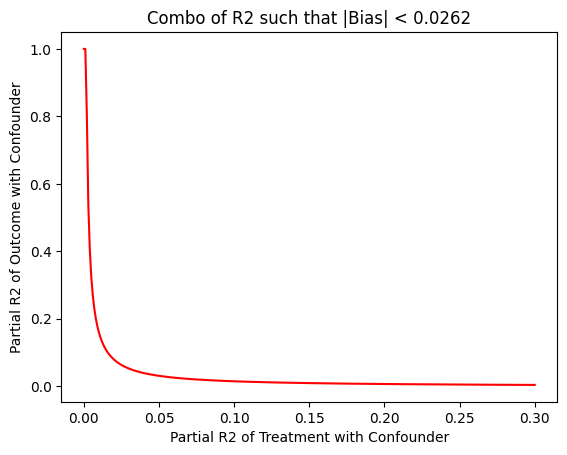

In [10]:
# Main estimate
beta = dml_model.params[1]

# Hypothetical values of partial R2s
R2_YC = 0.16
R2_DC = 0.01

# Elements of the bias equation
kappa = (R2_YC * R2_DC) / (1 - R2_DC)
variance_ratio = np.mean(dml_model.resid**2) / np.mean(resD**2)

# Compute square bias
BiasSq = kappa * variance_ratio

# Compute absolute value of the bias
print("absolute value of the bias:", np.sqrt(BiasSq))

# Plotting
gridR2_DC = np.arange(0, 0.301, 0.001)
gridR2_YC = kappa * (1 - gridR2_DC) / gridR2_DC
gridR2_YC = np.where(gridR2_YC > 1, 1, gridR2_YC)

plt.plot(gridR2_DC, gridR2_YC, color='red')
plt.xlabel('Partial R2 of Treatment with Confounder')
plt.ylabel('Partial R2 of Outcome with Confounder')
plt.title(f'Combo of R2 such that |Bias| < {np.round(np.sqrt(BiasSq), decimals=4)}')
plt.show()

## Packaging the Bias Analysis with some Automated Functions

We now automate the DML process and pass the estimates to functions to automate the sensitivity analysis. This is done in the R package sensmakr, which does not exist in Python.

In [11]:
def dml(X, D, y, modely, modeld, *, nfolds, classifier=False, cluster=True, clu=None):
    '''
    DML for the Partially Linear Model setting with cross-fitting

    Input
    -----
    X: the controls
    D: the treatment
    y: the outcome
    modely: the ML model for predicting the outcome y
    modeld: the ML model for predicting the treatment D
    nfolds: the number of folds in cross-fitting
    classifier: bool, whether the modeld is a classifier or a regressor

    clu: df column to cluster by
    cluster: bool, whether to use clustered standard errors

    Output
    ------
    point: the point estimate of the treatment effect of D on y
    stderr: the standard error of the treatment effect
    yhat: the cross-fitted predictions for the outcome y
    Dhat: the cross-fitted predictions for the treatment D
    resy: the outcome residuals
    resD: the treatment residuals
    epsilon: the final residual-on-residual OLS regression residual
    '''

    if nfolds > 1:
        cv = KFold(n_splits=nfolds, shuffle=True, random_state=123)  # shuffled k-folds
        yhat = cross_val_predict(modely, X, y, cv=cv, n_jobs=-1)  # out-of-fold predictions for y
        # out-of-fold predictions for D
        # use predict or predict_proba dependent on classifier or regressor for D
        if classifier:
            Dhat = cross_val_predict(modeld, X, D, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
        else:
            Dhat = cross_val_predict(modeld, X, D, cv=cv, n_jobs=-1)
    elif nfolds == -1:
        yhat = modely.fit(X, y).predict(X)
        if classifier:
            Dhat = modeld.fit(X, D).predict_proba(X)
        else:
            Dhat = modeld.fit(X, D).predict(X)

    # calculate outcome and treatment residuals
    resy = y - yhat
    resD = D - Dhat

    if cluster:
        # final stage ols clustered
        dml_data = pd.DataFrame({'resY': resY, 'resD': resD, 'cluster': clu})
    else:
        # final stage ols nonclustered
        dml_data = pd.DataFrame({'resY': resY, 'resD': resD})

    if cluster:
        # clustered standard errors
        ols_mod = smf.ols(formula='resY ~ 1 + resD', data=dml_data)
        ols_mod = ols_mod.fit(cov_type='cluster', cov_kwds={"groups": dml_data['cluster']})
    else:
        # regular ols
        ols_mod = smf.ols(formula='resY ~ 1 + resD', data=dml_data).fit()

    point = ols_mod.params[1]
    stderr = ols_mod.bse[1]
    epsilon = ols_mod.resid

    return point, stderr, yhat, Dhat, resy, resD, epsilon

In [12]:
def summary(point, stderr, yhat, Dhat, resy, resD, epsilon, X, D, y, *, name):
    '''
    Convenience summary function that takes the results of the DML function
    and summarizes several estimation quantities and performance metrics.
    '''
    return pd.DataFrame({'estimate': point,  # point estimate
                         'stderr': stderr,  # standard error
                         'lower': point - 1.96 * stderr,  # lower end of 95% confidence interval
                         'upper': point + 1.96 * stderr,  # upper end of 95% confidence interval
                         'rmse y': np.sqrt(np.mean(resy**2)),  # RMSE of model that predicts outcome y
                         'rmse D': np.sqrt(np.mean(resD**2))  # RMSE of model that predicts treatment D
                         }, index=[name])


In [13]:
def dml_sensitivity_bounds_single(res, eta_ysq, eta_asq, inds=None, return_stderr=False):
    ''' Sensitivity analysis, specialized for the partially linear DML moment
    E[(yres - theta * Tres) * Tres]. `est` is a `LinearDML` estimator fitted
    with `cache_values=True` so that residuals are being stored after fitting.

    Input
    -----
    res : tuple (yres, Tres)
        outcome and treatment residuals from the DML procedure
    eta_ysq : float
        posited partial R^2 for the outcome, that the unobserved confounder explains
    eta_asq : float
        posited partial R^2 for the treatment, that the unobserved confounder explains
    inds : list of int or None, optional (default=None)
        subset of samples to use for this analysis; useful for sub-population analysis
    return_stderr : bool, optional (default=False)
        whether to return standard errors for the lower and upper bound

    Returns
    -------
    lower : lower bound of confidence set
    lower_stderr : standard error for the lower bound (not returned if `return_stderr=False`)
    upper : upper bound of confidence set
    upper_stderr : standard error for the upper bound (not returned if `return_stderr=False`)
    '''
    if inds is None:
        inds = np.arange(res[0].shape[0])
    yres, Tres = res
    yres, Tres = yres[inds], Tres[inds]
    nusq = np.mean(Tres ** 2)
    theta = np.mean(yres * Tres) / nusq
    sigmasq = np.mean((yres - Tres * theta)**2)
    S = np.sqrt(sigmasq / nusq)
    Casq = eta_asq / (1 - eta_asq)
    Cgsq = eta_ysq
    error = S * np.sqrt(Casq * Cgsq)

    if not return_stderr:
        return theta - error, theta + error

    psi_theta = (yres - Tres * theta) * Tres / nusq
    psi_sigmasq = (yres - Tres * theta)**2 - sigmasq
    psi_nusq = Tres**2 - nusq

    phi_plus = psi_theta
    phi_plus += (np.sqrt(Casq * Cgsq) / (2 * S)) * (-(sigmasq / (nusq**2)) * psi_nusq + (1 / nusq) * psi_sigmasq)
    stderr_plus = np.sqrt(np.mean(phi_plus**2) / phi_plus.shape[0])

    phi_minus = psi_theta
    phi_minus -= (np.sqrt(Casq * Cgsq) / (2 * S)) * (-(sigmasq / (nusq**2)) * psi_nusq + (1 / nusq) * psi_sigmasq)
    stderr_minus = np.sqrt(np.mean(phi_minus**2) / phi_minus.shape[0])
    return theta - error, stderr_minus, theta + error, stderr_plus

If we want reduce the uncertainty from sample splitting, we can re-run our $nfolds$ cross-fitting and aggregate with the median estimates. With 10 folds as above, there shouldn't be too much variance anyway, but we employ the following aggregation procedure anyway.

In [14]:
def dml_sensitivity_bounds(res_list, eta_ysq, eta_asq, alpha=None, inds=None):
    ''' Sensitivity analysis, specialized for the partially linear DML moment
    E[(yres - theta * Tres) * Tres]. `est` is a `LinearDML` estimator fitted
    with `cache_values=True` so that residuals are being stored after fitting.

    Input
    -----
    res_list : list of tuples (yres, Tres), or single tuple (yres, Tres)
        list of (outcome and treatment residuals from the DML procedure) on different
        random cross-fitting folds
    eta_ysq : float
        posited partial R^2 for the outcome, that the unobserved confounder explains
    eta_asq : float
        posited partial R^2 for the treatment, that the unobserved confounder explains
    alpha : float or None, optional (default=None)
        confidence level for confidence interval; if None, no uncertainty is incoprorated
    inds : list of int or None, optional (default=None)
        subset of samples to use for this analysis; useful for sub-population analysis

    Returns
    -------
    lower : lower bound of confidence set, incorporating uncertainty
    upper : upper bound of confidence set, incorporating uncertainty
    '''
    if not isinstance(res_list, list):
        res_list = [res_list]

    if alpha is None:
        lower, upper = zip(*[dml_sensitivity_bounds_single(res, eta_ysq, eta_asq, inds=inds, return_stderr=False)
                             for res in res_list])
        return np.median(lower), np.median(upper)
    else:
        lower, std_lower, upper, std_upper = zip(*[dml_sensitivity_bounds_single(res, eta_ysq, eta_asq,
                                                                                 inds=inds, return_stderr=True)
                                                   for res in res_list])
        std_lower = np.array(std_lower)
        std_upper = np.array(std_upper)
        lower = np.median(lower)
        lower -= scipy.stats.norm.ppf(1 - alpha / 2) * np.sqrt(np.median(std_lower**2) + np.var(lower))
        upper = np.median(upper)
        upper += scipy.stats.norm.ppf(1 - alpha / 2) * np.sqrt(np.median(std_upper**2) + np.var(upper))
        return lower, upper


def dml_sensitivity_contours(res_list, y_upper, a_upper, alpha=None, inds=None):
    ''' Specialized for linear DML. Sensitivity bounds contour plots based on a many trained doubly robust
    average moment models. If `alpha` is float, incorporates sampling uncertainty
    at the `alpha` level. Sensitivity parameter `eta_ysq` ranges in `[0, y_upper]`
    and parameter `eta_asq` ranges in `[0, a_upper]`.

    Input
    -----
    res_list : list of tuples (yres, Tres), or single tuple (yres, Tres)
        list of (outcome and treatment residuals from the DML procedure) on different
        random cross-fitting folds
    y_upper : float
        upper bound on posited partial R^2 for the outcome, that the unobserved confounder explains
    a_upper : float
        upper bound posited partial R^2 for the treatment, that the unobserved confounder explains
    alpha : float or None, optional (default=None)
        confidence level for confidence interval; if None, no uncertainty is incoprorated
    inds : list of int or None, optional (default=None)
        subset of samples to use for this analysis; useful for sub-population analysis

    Returns
    -------
    X, Y, Zlower, Zupper: contour plot arrays for the lower and upper bound of the confidence set
    '''
    xlist = np.linspace(0, a_upper, 100)
    ylist = np.linspace(0, y_upper, 100)
    X, Y = np.meshgrid(xlist, ylist)
    Zlower = np.zeros(X.shape)
    Zupper = np.zeros(X.shape)
    for itx in np.arange(X.shape[1]):
        for ity in np.arange(X.shape[0]):
            l, u = dml_sensitivity_bounds(res_list, Y[ity, itx], X[ity, itx], alpha=alpha, inds=inds)
            Zlower[ity, itx] = l
            Zupper[ity, itx] = u

    return X, Y, Zlower, Zupper

## Bias Analysis with the Automated Functions

In [15]:
# DML with RLasso
modely = make_pipeline(StandardScaler(), lasso_model())
modeld = make_pipeline(StandardScaler(), lasso_model())

# Run DML model with no crossfitting (change nfolds to >1 to use crossfitting)
result_lasso = dml(controls, directlyharmedR, peacefactorR, modely, modeld, nfolds=-1,
                   classifier=False, clu=data['village'], cluster=True)
table_lasso = summary(*result_lasso, controls, directlyharmedR, peacefactorR, name='RLasso')
table_lasso

,estimate,stderr,lower,upper,rmse y,rmse D
RLasso,0.100336,0.024427,0.052459,0.148214,0.247114,0.374477


In [16]:
resY_lasso, resD_lasso = result_lasso[4], result_lasso[5]
print(("Controls explain the following fraction of variance of Outcome",
       max(1 - np.var(resY_lasso) / np.var(peacefactorR), 0)))
print(("Controls explain the following fraction of variance of Treatment",
       max(1 - np.var(resD_lasso) / np.var(directlyharmedR), 0)))

('Controls explain the following fraction of variance of Outcome', 0.12510755909046)
('Controls explain the following fraction of variance of Treatment', 0.011984237974717593)


In [17]:
res = (resY_lasso, resD_lasso)

In [18]:
print("[beta - phi, beta + phi]: ", dml_sensitivity_bounds(res, 0.16, 0.01))

[beta - phi, beta + phi]:  (np.float64(0.07411642707725397), np.float64(0.12655676829499982))


In [19]:
eta_asq, eta_ysq, lower, upper = dml_sensitivity_contours(res, 0.4, 0.4, alpha=0.05)
# Sensitivity parameter `eta_ysq` = R2_{Y ~ A|D} ranges in `[0, y_upper]`
# and `eta_asq` = R2_{D ~ A} ranges in `[0, a_upper]`.

Text(0, 0.5, 'Partial R2 of confounder(s) with the outcome')

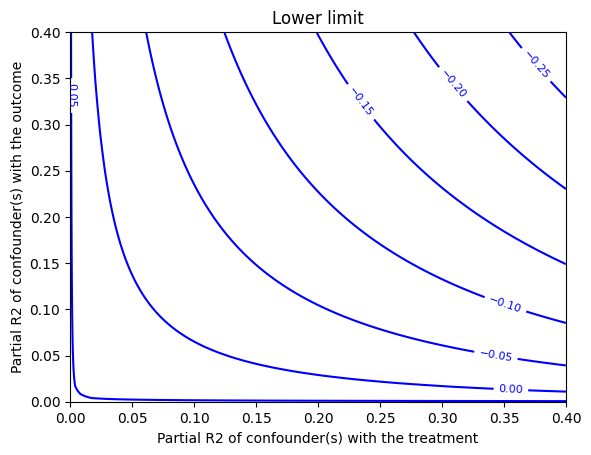

In [20]:
contours = plt.contour(eta_asq, eta_ysq, lower, 6, linestyles='-', colors='blue')
plt.clabel(contours, inline=True, fontsize=8)
plt.title('Lower limit')
plt.xlabel('Partial R2 of confounder(s) with the treatment')
plt.ylabel('Partial R2 of confounder(s) with the outcome')

## Reducing Instability by Calling DML Multiple Times

In [21]:
# redefine models without setting state -- random_state controls train_test_split downstream
modely = make_pipeline(StandardScaler(), lasso_model())
modeld = make_pipeline(StandardScaler(), lasso_model())
res_lasso_list = []
for i in range(5):
    result_lasso = dml(Z, directlyharmedR, peacefactorR, modely, modeld, nfolds=10,
                       classifier=False, clu=data['village'], cluster=True)
    resY_lasso, resD_lasso = result_lasso[4], result_lasso[5]
    res_lasso_list.append((resY_lasso, resD_lasso))

In [22]:
print("[beta - phi, beta + phi]: ", dml_sensitivity_bounds(res_lasso_list, 0.16, 0.01))
alpha = 0.05
print(f"With Sampling Uncertainty at the {alpha} level:",
      dml_sensitivity_bounds(res_lasso_list, .16, .01, alpha=alpha))

[beta - phi, beta + phi]:  (np.float64(0.0741795373130083), np.float64(0.12655721535240178))
With Sampling Uncertainty at the 0.05 level: (np.float64(0.029360350378818033), np.float64(0.17133438983990104))


## Random Forest for partialling out

The following code does DML with clustered standard errors by village

In [23]:
# DML with Random Forests.
modely = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=123)
modeld = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=123)

# Run DML model with nfolds folds of cross-fitting (computationally intensive)
result_RF = dml(Z, directlyharmedR, peacefactorR, modely, modeld, nfolds=10,
                classifier=False, clu=data['village'], cluster=True)
table_RF = summary(*result_RF, Z, directlyharmedR, peacefactorR, name='RF')
table_RF

,estimate,stderr,lower,upper,rmse y,rmse D
RF,0.089426,0.023022,0.044302,0.13455,0.256552,0.39034


In [24]:
resY_RF, resD_RF = result_RF[4], result_RF[5]
print(("Controls explain the following fraction of variance of Outcome",
       max(1 - np.var(resY_RF) / np.var(peacefactorR), 0)))
print(("Controls explain the following fraction of variance of Treatment",
       max(1 - np.var(resD_RF) / np.var(directlyharmedR), 0)))

('Controls explain the following fraction of variance of Outcome', 0.05716652667337452)
('Controls explain the following fraction of variance of Treatment', 0)


In [25]:
print("[beta - phi, beta + phi]: ", dml_sensitivity_bounds((resY_RF, resD_RF), 0.16, 0.01, alpha=0.05))

[beta - phi, beta + phi]:  (np.float64(0.02007698288992018), np.float64(0.16367052540652904))


## Reducing Instability by Calling DML Many Times

In [26]:
# redefine models without setting state -- random_state controls train_test_split downstream
modely = RandomForestRegressor(n_estimators=100, min_samples_leaf=5)
modeld = RandomForestRegressor(n_estimators=100, min_samples_leaf=5)
res_RF_list = []
for i in range(5):
    result_RF = dml(Z, directlyharmedR, peacefactorR, modely, modeld, nfolds=10,
                    classifier=False, clu=data['village'], cluster=True)
    resY_RF, resD_RF = result_RF[4], result_RF[5]
    res_RF_list.append((resY_RF, resD_RF))

In [27]:
print("[beta - phi, beta + phi]: ", dml_sensitivity_bounds(res_RF_list, 0.16, 0.01))
alpha = 0.05
print(f"With Sampling Uncertainty at the {alpha} level:",
      dml_sensitivity_bounds(res_RF_list, .16, .01, alpha=alpha))

[beta - phi, beta + phi]:  (np.float64(0.06805979398003933), np.float64(0.12032338578107826))
With Sampling Uncertainty at the 0.05 level: (np.float64(0.022461984127431826), np.float64(0.16587823755717301))


Text(0, 0.5, 'Partial R2 of confounder(s) with the outcome')

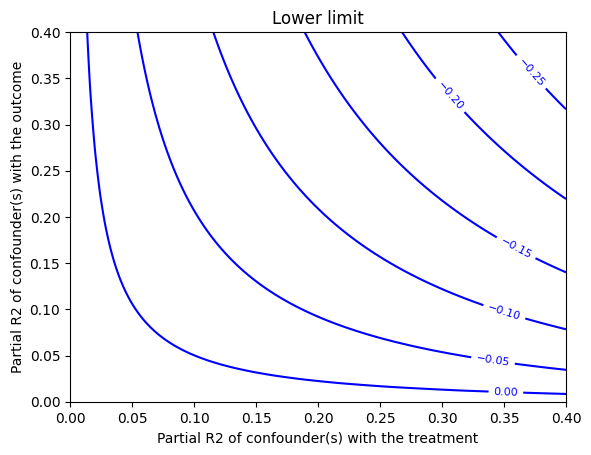

In [28]:
alpha = 0.05
eta_asq, eta_ysq, lower, upper = dml_sensitivity_contours(res_RF_list, 0.4, 0.4, alpha=alpha)
contours = plt.contour(eta_asq, eta_ysq, lower, 6, linestyles='-', colors='blue')
plt.clabel(contours, inline=True, fontsize=8)
plt.title('Lower limit')
plt.xlabel('Partial R2 of confounder(s) with the treatment')
plt.ylabel('Partial R2 of confounder(s) with the outcome')